In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

In [2]:
NUM_SAMPLES: int = 1000
STATE: int = 2023
IN_FEATURES: int = 2
OUT_FEATURES: int = 3
CLASS_SEP = 2
TEMPLATE = "ggplot2"

In [3]:
import torch
from sklearn.datasets import make_moons, make_circles, make_classification
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


PALETTE = px.colors.qualitative.Plotly
figKwargs = dict(
    width=500,
    height=400,
)
showKwargs = dict(
    renderer="png", scale=2
)  # change renderer to "" to use interactive plots

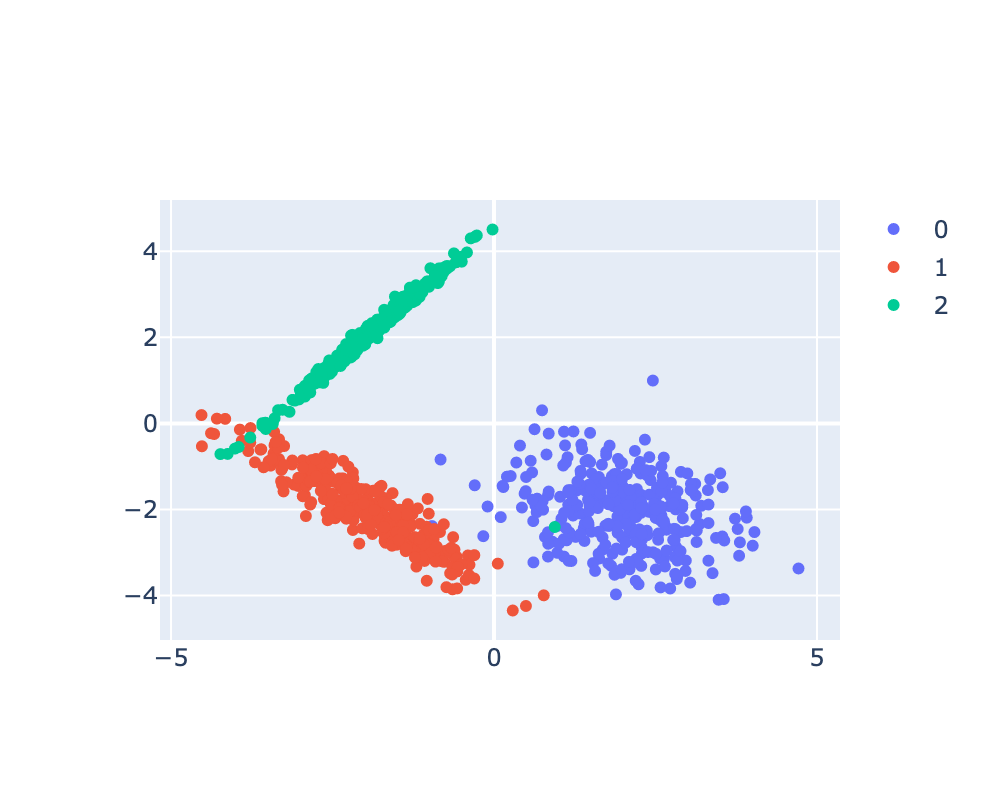

In [4]:
X, y = make_classification(
    n_samples=NUM_SAMPLES,
    n_features=IN_FEATURES,
    n_informative=IN_FEATURES,
    n_clusters_per_class=1,
    n_redundant=0,
    n_classes=OUT_FEATURES,
    class_sep=CLASS_SEP,
    random_state=STATE,
)
color = [PALETTE[int(i)] for i in y]
labels = {PALETTE[i]: i for i in range(OUT_FEATURES)}
labels["color"] = "label"
# X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.long)
fig = go.Figure(layout=figKwargs)
for cls in torch.unique(y):
    x = X[y == cls]
    y_ = cls.item()
    fig.add_trace(
        go.Scatter(
            x=x[:, 0], y=x[:, 1], mode="markers", name=f"{y_}", line_color=PALETTE[y_]
        )
    )
fig.show(**showKwargs)

In [5]:
from ml.losses.classification import CrossEntropyLoss
from ml.activations.functional import softmax
from ml.activations import ReLU, Sigmoid
from ml.models.linear import Linear
from ml.models.nn import Sequential
from ml.optim import SGD
from functools import partial

activation = partial(softmax, dim=1)

LR = 0.1
REG = 0.1
N = 100

model = Sequential(
    [Linear(IN_FEATURES, 16), ReLU(), Linear(16, OUT_FEATURES)], activation=activation
)
optim = SGD(model.parameters(), model.grad(), LR, REG)
criterion = CrossEntropyLoss()

t_model = torch.nn.Sequential(
    torch.nn.Linear(IN_FEATURES, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, OUT_FEATURES),
)
# Start with same parameters
for t, m in zip(t_model, model.layers):
    if isinstance(t, torch.nn.Linear):
        t.weight.data = m.weight.data.clone()
        t.bias.data = m.bias.data.clone()
t_criterion = torch.nn.CrossEntropyLoss()

In [6]:
model.fit(X, y.to(torch.long), criterion, optim, N)

100%|██████████| 100/100 [00:00<00:00, 1067.76it/s]


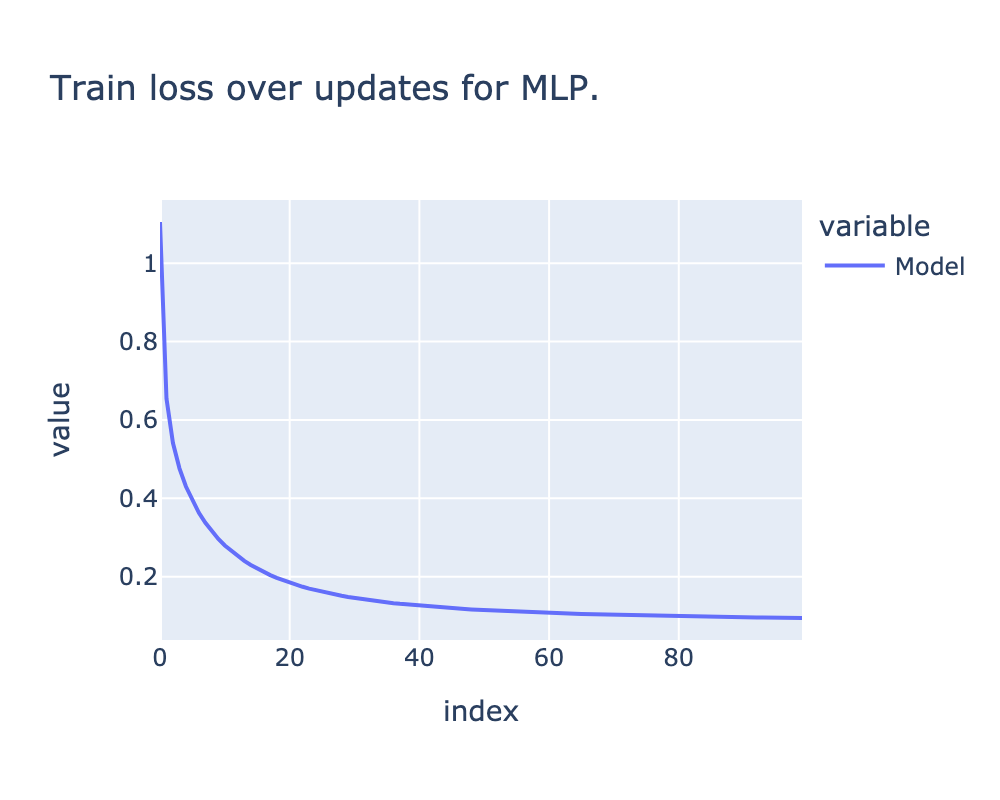

In [7]:
data = pd.DataFrame(dict(Model=model.history))
fig = px.line(
    data,
    title="Train loss over updates for MLP.",
    **figKwargs,
)
fig.show(**showKwargs)

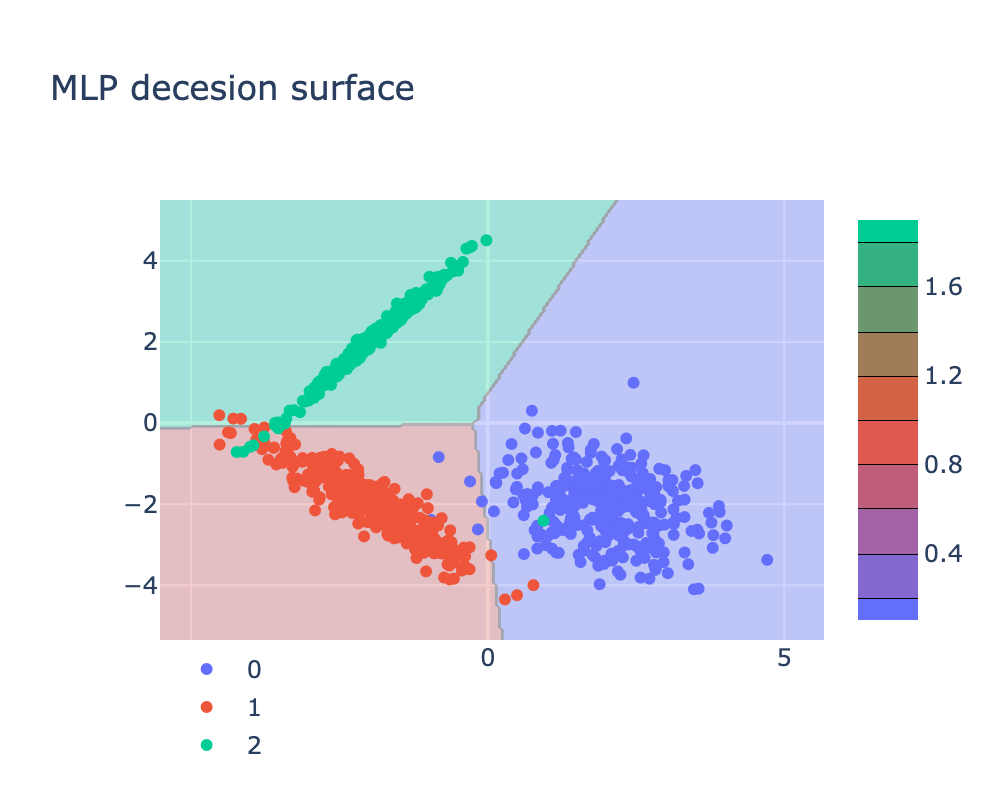

In [8]:
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = torch.meshgrid(
    torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h), indexing="ij"
)
levels = torch.linspace(0, 1, 1000)
grid = torch.dstack([xx.ravel(), yy.ravel()])[0]
gridOut = model.predict(grid).argmax(1, keepdim=True)

fig = go.Figure(
    data=go.Contour(
        x=xx[:, 0],
        y=yy[0],
        z=gridOut.reshape(xx.shape).T,
        opacity=0.3,
        line_smoothing=1.0,
        colorscale=PALETTE[:3],
    )
)

for cls in torch.unique(y):
    x = X[y == cls]
    y_ = int(cls.item())
    fig.add_trace(
        go.Scatter(
            x=x[:, 0], y=x[:, 1], mode="markers", name=f"{y_}", line_color=PALETTE[y_]
        )
    )
fig.update_layout(
    title="MLP decesion surface",
    legend=dict(yanchor="top", y=0.00, xanchor="left", x=0.01),
    **figKwargs,
)
fig.show(**showKwargs)

In [9]:
from ml.metrics import get_stats, accuracy
import torch.nn.functional as F

output = model.predict(X)
preds = output.argmax(1)
stats = get_stats(F.one_hot(preds), F.one_hot(y))
accuracy(*stats)

tensor(0.9847)